In [1]:
import sys
sys.path.append('/home/campbell/yulee/DAMM/new/code/pro')

from funcs1 import *

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
cohort = 'eddy'
ss = 10

BatchSize = 128
learnRate = 1e-3
nm = 'student'
so = None
rr = 0
rv = 100 
r = 0

In [3]:
analysisProteins = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS']

pretty_printing = ['B220', 'CCR7', 'CD11b', 'CD11c', 'CD19', 'CD28', 'CD3', 'CD31', 'CD4',
       'CD45', 'CD49b', 'CD68', 'CD73', 'CD8', 'CTLA4', 'DNA1', 'DNA3',
       'Epithelium', 'FOXP3', 'GATA3', 'GFP', 'GranzymeB', 'HA', 'ICOS',
       'IL7Ra', 'Ly6G', 'MHCII', 'PD1', 'PDL1', 'PNAd', 'Perforin', 'RFP',
       'S100A8-9', 'Stroma', 'TBET', 'TCF1', 'YAP', 'iNOS', 'size']

tr_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_exp.h5ad'.format(cohort, ss))
te_exp = sc.read_h5ad('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_exp.h5ad'.format(cohort, ss))

tr_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/tr_so.zip'.format(cohort, ss))
te_so = torch.load('/home/campbell/yulee/DAMM/new/data/{}/{}k/te_so.zip'.format(cohort, ss))

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


# Phenograph label

In [4]:
'''
pheno = pd.read_csv('/home/campbell/yulee/DAMM/new/res/basel/10k/pheno/model/phenograph_assignments_50_0.csv')
communities = np.array(pheno.iloc[:,1])
phenograph_nc = len(np.unique(communities))
pheno_exps = np.zeros((phenograph_nc, trY.shape[1]))
pheno_size = np.zeros(phenograph_nc)
for k in range(phenograph_nc):
    #phen_means[i,:] = Y[phen_assign.iloc[:,1]==i].mean(0)
    pheno_exps[k,:] = trY[communities==k].mean(0)
    pheno_size[k] = np.array(trS[communities==k]).mean()
pd.DataFrame(pheno_exps, columns = pretty_printing)
'''

"\npheno = pd.read_csv('/home/campbell/yulee/DAMM/new/res/basel/10k/pheno/model/phenograph_assignments_50_0.csv')\ncommunities = np.array(pheno.iloc[:,1])\nphenograph_nc = len(np.unique(communities))\npheno_exps = np.zeros((phenograph_nc, trY.shape[1]))\npheno_size = np.zeros(phenograph_nc)\nfor k in range(phenograph_nc):\n    #phen_means[i,:] = Y[phen_assign.iloc[:,1]==i].mean(0)\n    pheno_exps[k,:] = trY[communities==k].mean(0)\n    pheno_size[k] = np.array(trS[communities==k]).mean()\npd.DataFrame(pheno_exps, columns = pretty_printing)\n"

In [5]:
#import phenograph
import scanpy.external as sce

trY, trS, _, _, _ = prepData(tr_exp, 2, analysisProteins)
trYS = np.hstack((trY, trS.reshape(-1,1)))
pheno_labels, _, _ = sce.tl.phenograph(trYS, k=30)
#communities, _, _ = phenograph.cluster(np.hstack((trY, trS.reshape(-1,1))), k=30)
tr_exp.obs['pheno_label'] = pheno_labels.astype(str)

## set number of clusters
nc = len(np.unique(pheno_labels))

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.423940420150757 seconds
Jaccard graph constructed in 1.252150535583496 seconds
Wrote graph to binary file in 0.29529285430908203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794149
After 10 runs, maximum modularity is Q = 0.797324
Louvain completed 30 runs in 10.4759361743927 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 17.73094367980957 seconds


In [6]:
phenograph_nc = len(np.unique(pheno_labels))
pheno_centers = np.zeros((phenograph_nc, trYS.shape[1]))
for k in range(phenograph_nc):
    #phen_means[i,:] = Y[phen_assign.iloc[:,1]==i].mean(0)
    pheno_centers[k,:] = trYS[pheno_labels==k].mean(0)
#pd.DataFrame(pheno_centers, columns = pretty_printing) #.to_csv("test.csv")

# Kmeans Initalization

In [7]:
_, _, Theta, kms_labels, kms_centers = prepData(tr_exp, nc, analysisProteins)

## save kmeans results as damm initialization
#torch.save(Theta, output_theta0)
#torch.save(Theta, "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/theta0_nc{}_{}_rv{}_so{}_rr{}_test".format(cohort, ss, nc, nm, rv, so, rr))

## save kmeans labels (in anndata object)
tr_exp.obs['kms_label'] = kms_labels.astype(str)

## save kmeans centers
kms_sorted_by_count = pd.Series(kms_labels).value_counts().index
kms_centers = kms_centers[kms_sorted_by_count]
#pd.DataFrame(kms_centers, columns = pretty_printing).to_csv('test.csv')

In [8]:
## compute training and test set
trFY, trFS, trFL = simulate_data(trY, trS)

teY, teS, _, _, _ = prepData(te_exp, nc, analysisProteins)
teFY, teFS, teFL = simulate_data(teY, teS)

# Random Forest

In [9]:
import joblib
## get random forest classifier
rf = RandomForestClassifier()
rf.fit(trYS, trFL)
rf_p_fake_singlet = rf.predict_proba(torch.hstack([teFY, teFS.reshape(-1,1)]))[:,1]
rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec = evalM(rf_p_fake_singlet, teFL)
#torch.hstack([teFY, teFS.reshape(-1,1)])
#joblib.dump(rf, "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/rf_nc{}_{}_rv{}_so{}_rr{}_test.joblib".format(cohort, ss, nc, nm, rv, so, rr))

# DAMM

In [10]:
## run DAMM
loss, Theta = trainWFD(ConcatDataset(trY, trS, trFY, trFS, trFL), Theta, BatchSize, nm, learnRate, rv, so, tr_so, rr)
#torch.save([loss, Theta], "/home/campbell/yulee/DAMM/new/res/{}/{}k/damm/theta1_nc{}_{}_rv{}_so{}_rr{}_test".format(cohort, ss, nc, nm, rv, so, rr))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [11]:
with torch.no_grad():
    ## watch out for when input matrix are big!!
    _, _, _ , damm_p_fake_singlet = compute_posteriors_nll_p_singlet(teFY, teFS, Theta, nm, so, te_so, rr)
    
    tn, fp, fn, tp, acc, f1, sens, spec = evalM(damm_p_fake_singlet, teFL)
    cor2 = np.corrcoef(damm_p_fake_singlet, rf_p_fake_singlet)

    iter_out = [nc, nm, rv, so, rr, r, len(np.where(damm_p_fake_singlet > 0.5)[0]), tn, fp, fn, tp, acc, f1, sens, spec, 
            len(np.where(rf_p_fake_singlet > 0.5)[0]), rf_tn, rf_fp, rf_fn, rf_tp, rf_acc, rf_f1, rf_sens, rf_spec, cor2[0,1]]

    output_pred_doublet = pd.Series(iter_out) #.to_csv(output_pred_doublet)

    damm_pred_singlet_label, damm_pred_singlet_cluster_assig_label, _ = get_assign_labels(trY, trS, Theta, nm, so, tr_so, rr)
    
    damm_sorted_by_count = pd.Series(damm_pred_singlet_cluster_assig_label[0]).value_counts().index
    
    ## save damm labels
    tr_exp.obs['damm_label'] = len(np.unique(damm_pred_singlet_cluster_assig_label[0]))
    tr_exp.obs.iloc[np.where(damm_pred_singlet_label[0] == 0)[0],-1] = np.array(damm_pred_singlet_cluster_assig_label[0])
    tr_exp.obs['damm_label'] = tr_exp.obs['damm_label'].astype(str)
    
    ## save damm centers
    damm_centers = np.array(torch.hstack([Theta['log_mu'], Theta['log_psi'].reshape(-1,1)]).exp())
    damm_centers = damm_centers[damm_sorted_by_count]
    # pd.DataFrame(damm_centers[damm_sorted_by_count], columns = pretty_printing)

In [47]:
oPath = "DAMM/new/res/{}/{}k/damm/model/".format(cohort, ss)
olabels = oPath + "labels_pn{}_{}_rv{}_so{}_rr{}_{}.csv".format(2, nm, rv, so, rr, r)

In [48]:
olabels

'DAMM/new/res/eddy/10k/damm/model/labels_pn2_student_rv100_soNone_rr0_0.csv'

In [12]:
pd.DataFrame(pheno_centers, columns = pretty_printing)

,B220,CCR7,CD11b,CD11c,CD19,CD28,CD3,CD31,CD4,CD45,...,PNAd,Perforin,RFP,S100A8-9,Stroma,TBET,TCF1,YAP,iNOS,size
0,1.179985,4.411469,2.064531,0.833514,0.376463,0.838062,13.927265,1.570937,0.189381,0.741743,...,0.399186,0.222048,5.278979,0.146860,6.855165,0.547450,8.539648,0.758208,0.325087,37.744907
1,1.408592,2.826812,2.459137,0.568025,0.253267,0.461079,2.819721,1.697452,0.054742,0.753513,...,0.245727,0.116450,1.447895,0.123088,3.899097,0.379894,5.771360,0.450777,0.182849,39.095280
2,1.129477,4.380521,1.929936,0.658289,0.376023,0.822009,14.713990,1.604027,0.182479,0.769978,...,0.358695,0.224962,5.117833,0.142513,6.041781,0.527546,9.298527,0.715899,0.320088,21.611885
3,1.639769,2.566798,2.228122,0.539507,0.286901,0.447298,2.776993,1.684480,0.055462,0.732425,...,0.245267,0.108115,1.445235,0.117913,3.707278,0.355103,5.788443,0.481935,0.179680,28.290092
4,1.239122,2.733049,2.219536,0.568109,0.235276,0.436107,2.667475,1.750181,0.056141,0.693520,...,0.282331,0.120079,1.641597,0.114913,4.103206,0.363426,5.713541,0.615416,0.177865,16.110353
5,1.426299,4.465846,2.136870,0.887996,0.441647,0.839093,13.564108,1.547963,0.192943,0.715331,...,0.375845,0.224754,5.473810,0.153284,9.177643,0.582099,7.907948,0.786455,0.313480,53.215029
6,1.525891,2.692474,2.501838,0.560268,0.269463,0.439826,2.850796,1.781192,0.055784,0.736595,...,0.246346,0.114017,1.450845,0.126933,3.878605,0.383324,5.513003,0.551998,0.177192,52.707174
7,1.210624,4.960364,2.343186,1.091615,0.432460,0.798451,9.204613,1.576695,0.157039,0.646704,...,0.454686,0.216138,5.947187,0.163707,17.681352,0.589928,6.453317,0.973520,0.312287,28.268730
8,8.732306,1.203219,2.362775,0.413141,1.298312,0.299039,2.164099,2.150243,0.049713,0.658056,...,0.422811,0.113477,1.957301,0.115865,3.653657,0.345911,2.934180,1.160747,0.179229,34.588542
9,5.274929,1.973161,2.947403,0.576217,0.923346,0.395624,2.923319,1.857313,0.055521,0.699698,...,0.384612,0.126581,2.058772,0.139634,3.918753,0.445228,4.234495,0.803453,0.188960,73.597222


In [13]:
pd.DataFrame(kms_centers, columns = pretty_printing)

,B220,CCR7,CD11b,CD11c,CD19,CD28,CD3,CD31,CD4,CD45,...,PNAd,Perforin,RFP,S100A8-9,Stroma,TBET,TCF1,YAP,iNOS,size
0,2.254221,2.513455,2.272860,0.530935,0.382141,0.433453,2.827580,1.791084,0.055660,0.729647,...,0.348896,0.113671,1.570174,0.117904,3.891295,0.370940,5.399291,0.625114,0.181830,35.969288
1,1.794411,2.554052,2.181731,0.548117,0.307053,0.441727,2.787548,1.741193,0.055561,0.722910,...,0.308253,0.115100,1.574421,0.116033,3.859457,0.368986,5.641198,0.579884,0.177897,25.037225
2,2.534854,2.489931,2.488896,0.552284,0.415668,0.441983,2.880801,1.804355,0.056953,0.721910,...,0.301761,0.117413,1.608702,0.121128,3.811217,0.391154,5.257896,0.600252,0.182699,47.118135
3,1.184983,4.337064,1.952375,0.714110,0.377798,0.805115,12.760097,1.554153,0.179503,0.726618,...,0.359996,0.208122,5.101061,0.143016,7.059001,0.526010,8.538205,0.721829,0.319943,29.156359
4,3.324981,2.218231,2.354008,0.584442,0.554486,0.386111,2.881655,1.754433,0.058673,0.637892,...,0.478854,0.122028,2.065946,0.122845,4.151785,0.374359,4.335994,0.757338,0.183048,12.690418
5,1.395148,4.412515,2.055654,0.810546,0.421604,0.847588,14.051530,1.590521,0.192665,0.744505,...,0.500097,0.226966,5.379397,0.147565,7.100685,0.533801,8.420793,0.789752,0.327508,40.623393
6,3.815314,2.288108,2.637006,0.609573,0.686892,0.439597,3.354076,1.907683,0.065599,0.712393,...,0.514498,0.128087,2.192733,0.132648,4.456757,0.433858,4.852821,0.824051,0.195214,61.832326
7,1.309916,4.432344,2.066516,0.818000,0.419433,0.870204,14.994801,1.586298,0.204189,0.746660,...,0.404400,0.229178,5.505040,0.147891,7.454642,0.605562,8.426053,0.775759,0.320263,53.497561
8,1.225479,4.504464,1.969764,0.665066,0.405086,0.825923,15.128082,1.632838,0.180132,0.773934,...,0.373057,0.231672,5.196936,0.139306,6.018910,0.555797,9.522747,0.741030,0.320396,17.628920
9,11.811759,0.976073,2.303220,0.470031,1.785253,0.269112,2.733428,1.677084,0.055857,0.660329,...,0.562445,0.120976,2.319946,0.116620,3.550048,0.367921,2.208144,0.856836,0.183153,26.908434


In [14]:
pd.DataFrame(damm_centers, columns = pretty_printing)

,B220,CCR7,CD11b,CD11c,CD19,CD28,CD3,CD31,CD4,CD45,...,PNAd,Perforin,RFP,S100A8-9,Stroma,TBET,TCF1,YAP,iNOS,size
0,0.368157,2.369335,1.078064,0.197522,0.108586,0.384543,2.398081,1.434501,0.038269,0.682661,...,0.196647,0.080741,1.079211,0.062387,2.576847,0.170084,6.243671,0.231654,0.136643,28.066526
1,0.624882,2.665907,2.242265,0.644074,0.151265,0.381595,2.256420,1.497555,0.042867,0.649777,...,0.197162,0.099327,1.357754,0.112054,4.064926,0.220490,4.709605,0.338679,0.152717,33.827647
2,0.795800,3.009794,1.749169,0.312095,0.185058,0.545679,3.076224,1.803035,0.055664,0.880938,...,0.260687,0.121009,1.463563,0.099297,3.482722,0.273780,7.312908,0.358019,0.201165,33.547538
3,0.423535,5.197877,1.801941,0.507780,0.256337,0.901402,15.474960,1.524073,0.226953,0.747601,...,0.290897,0.214002,5.690685,0.137813,7.131328,0.374684,8.958522,0.626951,0.307125,37.615517
4,8.365193,0.677155,1.600135,0.202579,1.044779,0.172325,1.261032,1.477333,0.023313,0.587689,...,0.208170,0.080449,0.944019,0.077520,2.297275,0.171788,1.473058,0.440679,0.110487,26.566472
5,0.393700,3.401534,1.257377,0.267910,0.214154,0.661023,13.626305,1.278218,0.147650,0.628336,...,0.251451,0.174468,3.856203,0.096421,4.482521,0.273207,8.342307,0.490630,0.235467,26.611472
6,0.419042,4.374055,1.750350,0.269592,0.235529,0.825878,15.220680,1.683331,0.160187,0.854610,...,0.312036,0.234816,4.686661,0.137726,5.136110,0.463768,10.437654,0.630800,0.357567,28.964466
7,1.097603,3.401822,1.806218,0.741074,0.365837,0.675546,10.106170,1.408867,0.149322,0.581513,...,0.299107,0.185525,4.793261,0.126293,8.409160,0.378881,6.372733,0.714641,0.278687,35.323954
8,0.562393,4.496530,2.693750,0.863883,0.337766,1.024279,12.473439,1.780426,0.205331,0.796131,...,0.335974,0.257496,6.361260,0.181598,9.680838,0.760579,8.224672,0.919161,0.417135,34.396045
9,1.536837,2.557430,3.978845,0.953674,0.273835,0.515412,2.897395,2.021843,0.057168,0.842137,...,0.250137,0.145351,1.881946,0.194389,5.080968,0.436374,5.133286,0.630156,0.219294,24.816237


# Loss Curve

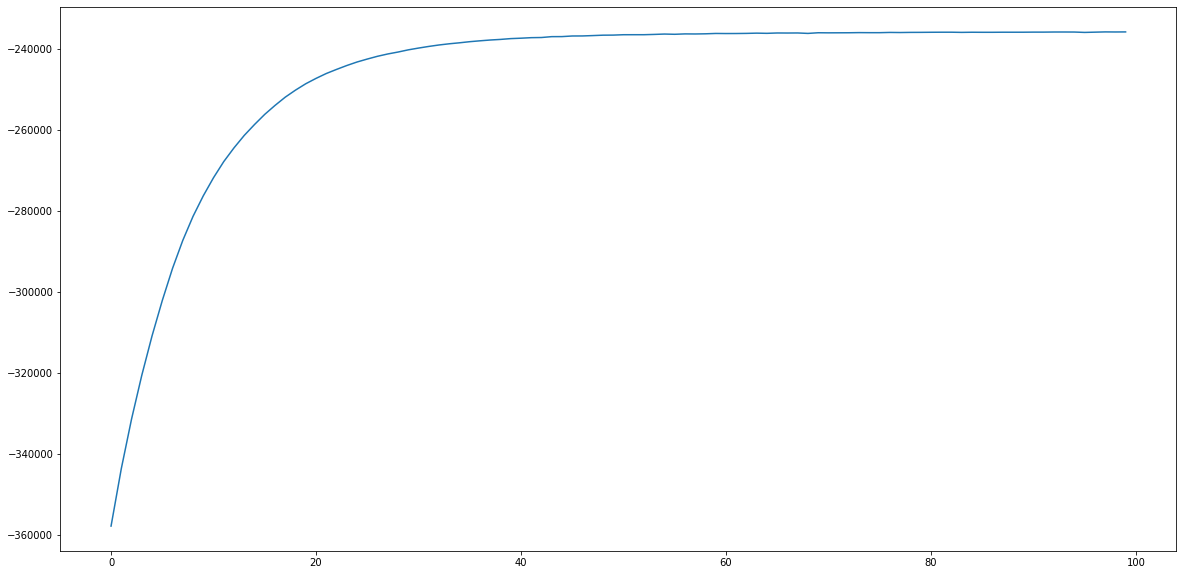

In [15]:
## total loss
plt.plot(np.array(loss)[:,0])

# Doublet Probability

/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pheno_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kms_label' as categorical
/home/campbell/yulee/.local/share/virtualenvs/yulee-9RaDnU2W/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `in

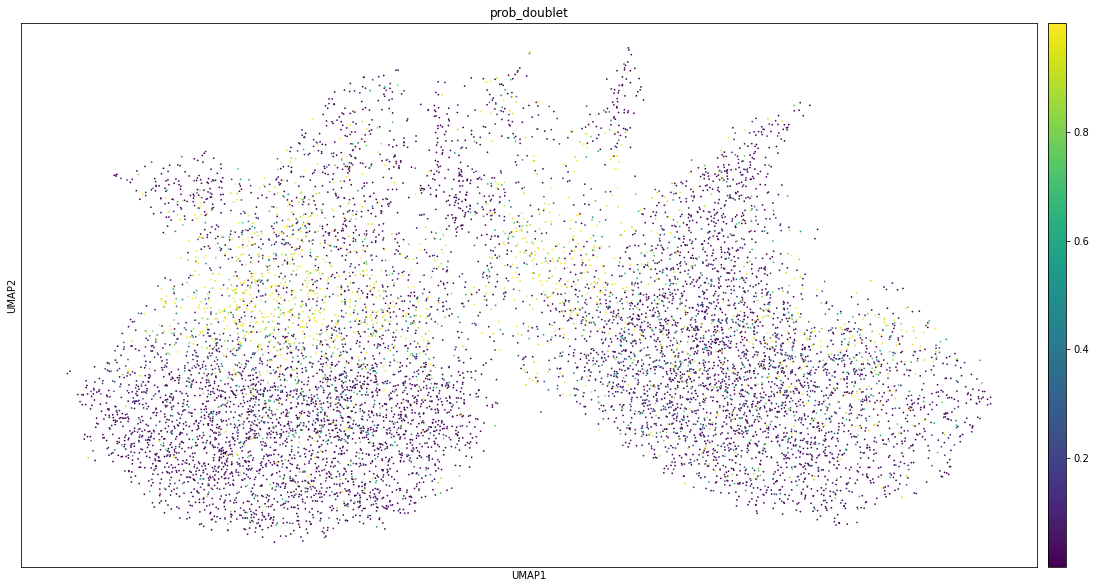

In [16]:
with torch.no_grad():
    _, _, _, p_singlet = compute_posteriors_nll_p_singlet(trY, trS, Theta, nm, so, tr_so, rr)
    
tr_exp.obs['prob_doublet'] = 1 - np.array(p_singlet.detach())
sc.pl.umap(tr_exp, color="prob_doublet")

In [17]:
sum(p_singlet.detach() > 0.5)

tensor(8002)

# Expression Heatmap (scaled)

In [18]:
scaler = MinMaxScaler()
#s2 = scaler.fit(phen_means)
s2 = scaler.fit(np.vstack([pheno_centers, kms_centers, damm_centers]))

Text(156.0, 0.5, 'Cluster')

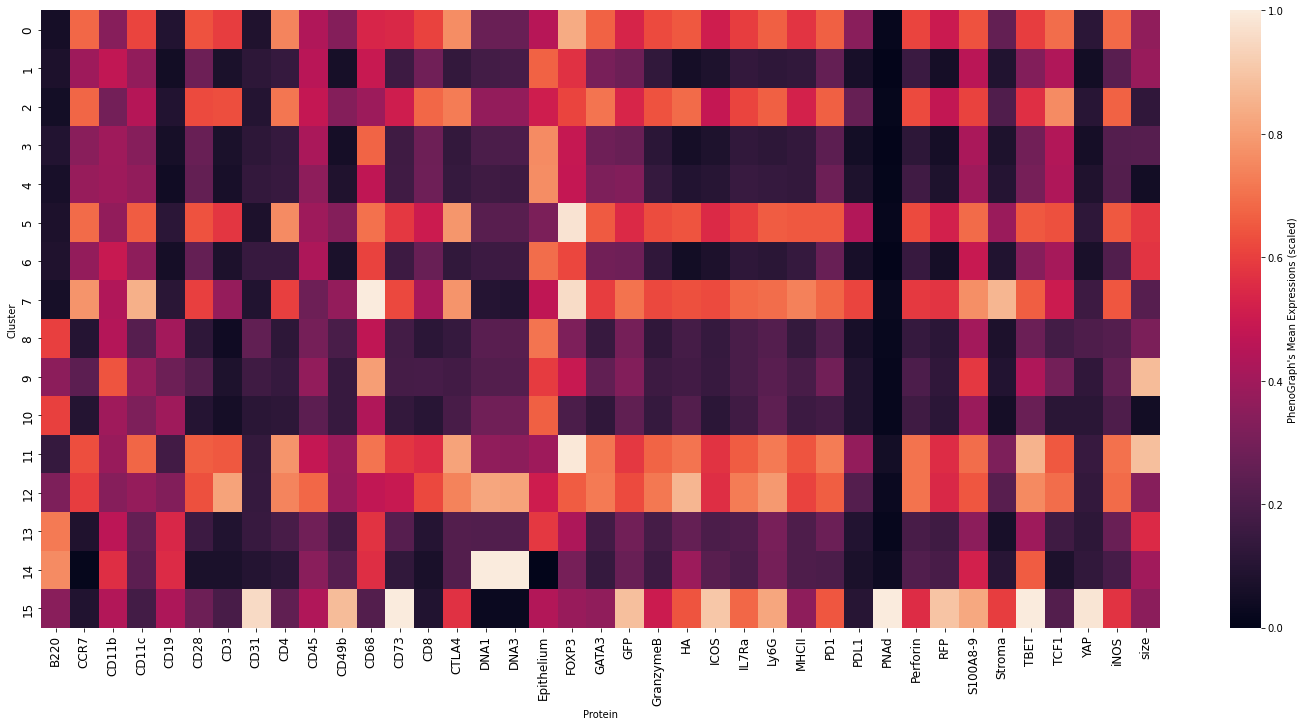

In [19]:
## phenograph
s3 = scaler.transform(pheno_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "PhenoGraph's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [20]:
## doublet probability for each cluster
rf.predict_proba(pheno_centers)[:,0]

array([0.15, 0.11, 0.11, 0.11, 0.15, 0.58, 0.53, 0.14, 0.36, 0.99, 0.25,
       1.  , 0.11, 0.87, 0.56, 0.2 ])

Text(156.0, 0.5, 'Cluster')

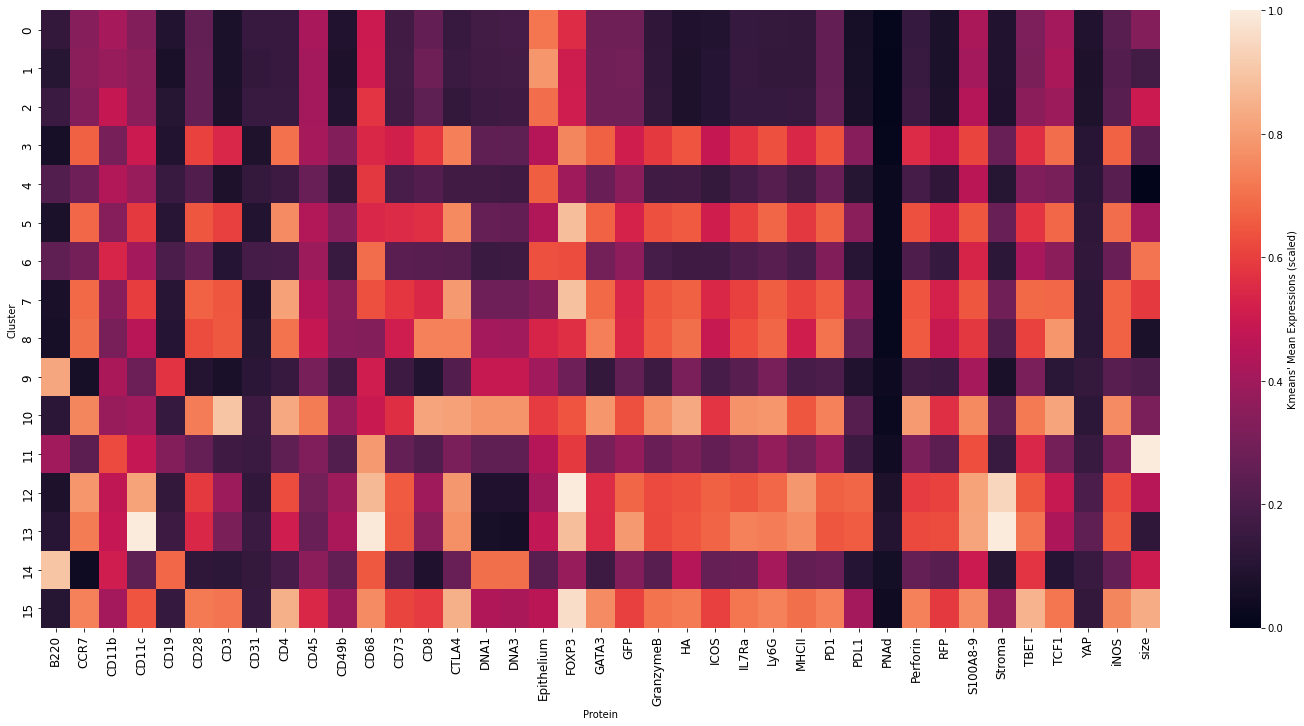

In [21]:
## kmeans
s3 = scaler.transform(kms_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Kmeans' Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [22]:
## doublet probability for each cluster
rf.predict_proba(kms_centers)[:,0]

array([0.22, 0.15, 0.36, 0.19, 0.24, 0.07, 0.99, 0.56, 0.09, 0.27, 0.11,
       0.99, 0.29, 0.16, 0.63, 0.98])

Text(156.0, 0.5, 'Cluster')

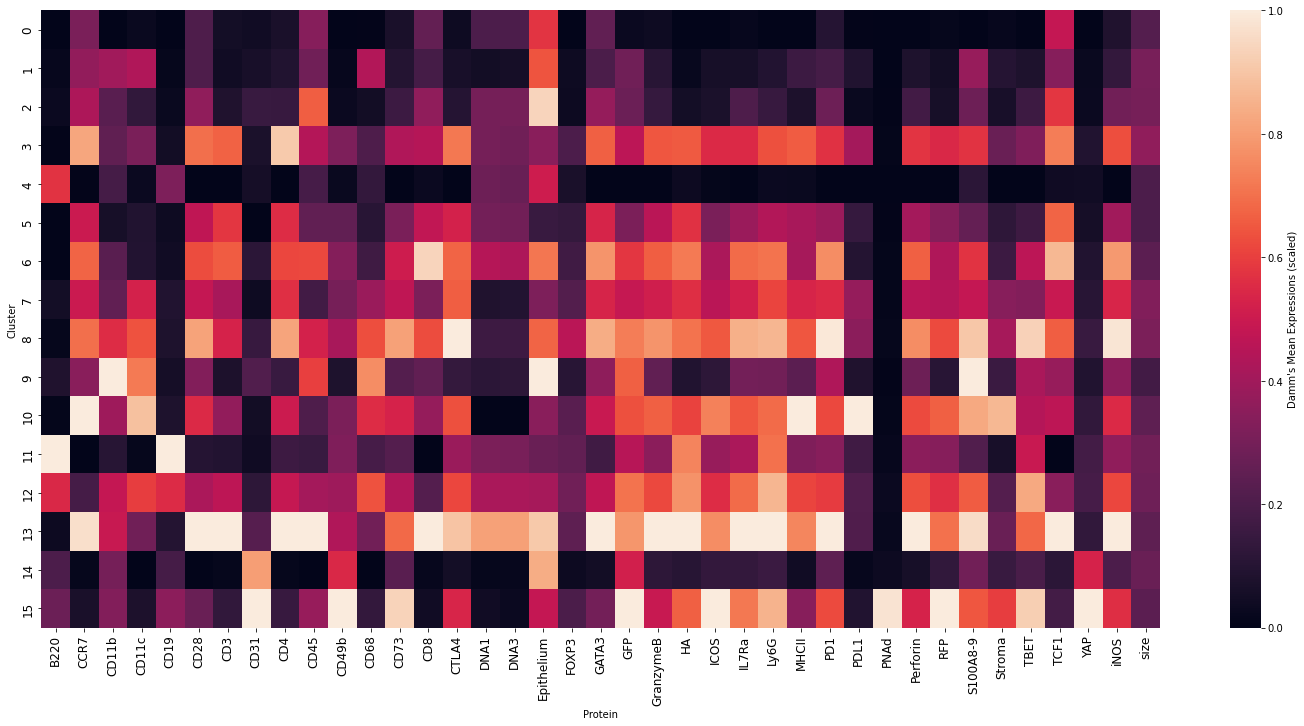

In [23]:
## damm
s3 = scaler.transform(damm_centers)
mat = pd.DataFrame(s3, columns = pretty_printing)
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "Damm's Mean Expressions (scaled)"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

In [24]:
## doublet probability for each cluster
rf.predict_proba(damm_centers)[:,0] 

array([0.07, 0.08, 0.07, 0.06, 0.2 , 0.08, 0.1 , 0.21, 0.19, 0.15, 0.07,
       0.02, 0.17, 0.06, 0.09, 0.08])

# Expression Heatmap (arcsinh)

Text(156.0, 0.5, 'Cluster')

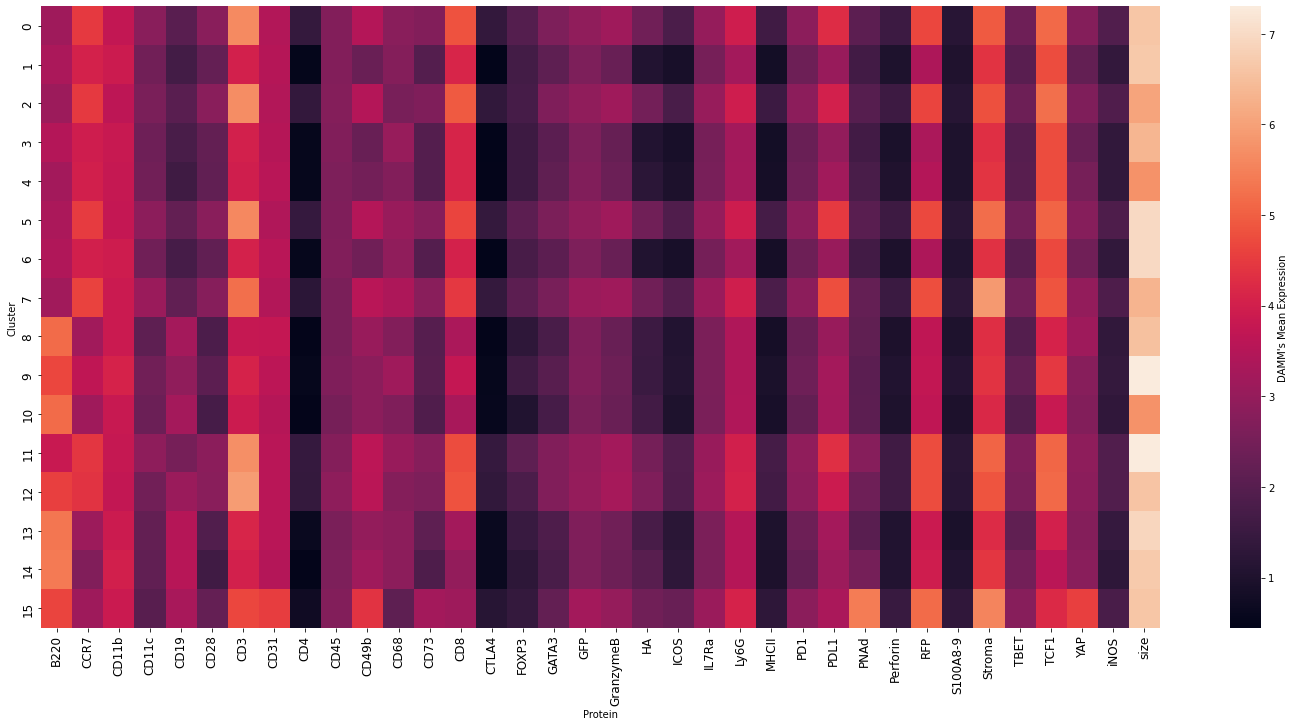

In [25]:
#mat = pd.DataFrame(np.arcsinh(np.array(pheno_exps)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([pheno_centers[:,:15], pheno_centers[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

Text(156.0, 0.5, 'Cluster')

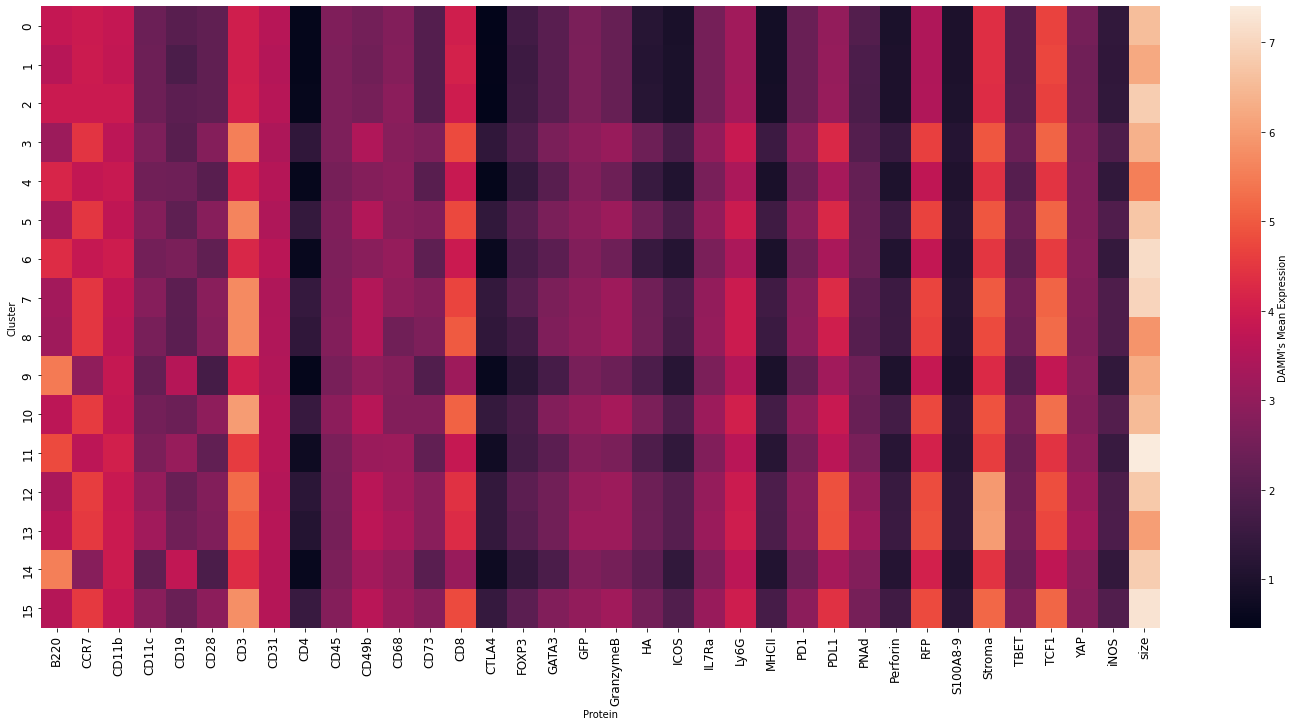

In [26]:
#mat = pd.DataFrame(np.arcsinh(np.array(smu0)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([kms_centers[:,:15], kms_centers[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

Text(156.0, 0.5, 'Cluster')

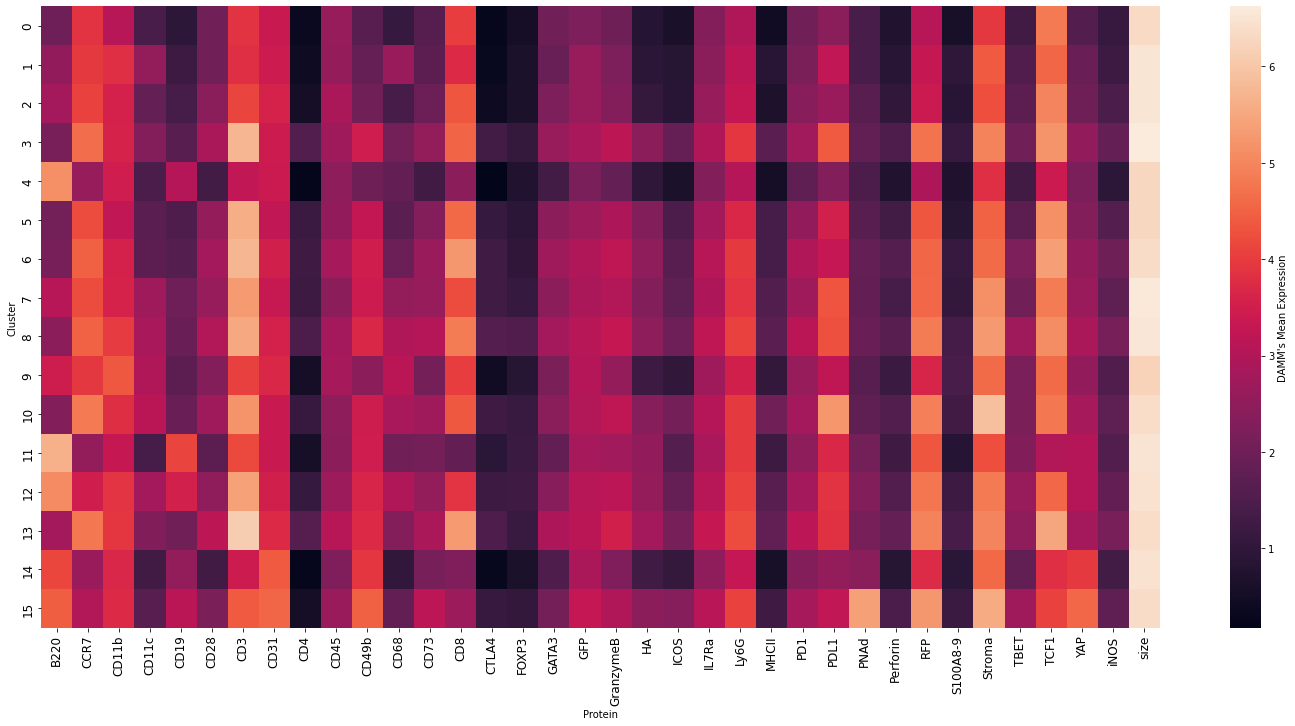

In [27]:
#mat = pd.DataFrame(np.arcsinh(np.array(smu1)/0.1), columns = pretty_printing)
mat = pd.DataFrame(np.arcsinh(np.hstack([damm_centers[:,:15], damm_centers[:,18:]])/0.1), columns = np.hstack([pretty_printing[:15], pretty_printing[18:]]))
ax = sns.heatmap(mat, yticklabels = True, xticklabels = True, cbar_kws={'label': "DAMM's Mean Expression"})
ax.set_xticklabels(ax.get_xticklabels(), size = 12, horizontalalignment = 'center')
ax.set_yticklabels(ax.get_yticklabels(), size = 12, verticalalignment = 'center')
ax.figure.tight_layout()
plt.xlabel("Protein")
plt.ylabel("Cluster")

# UMAP of PhenoGraph/Kmeans/DAMM clusters

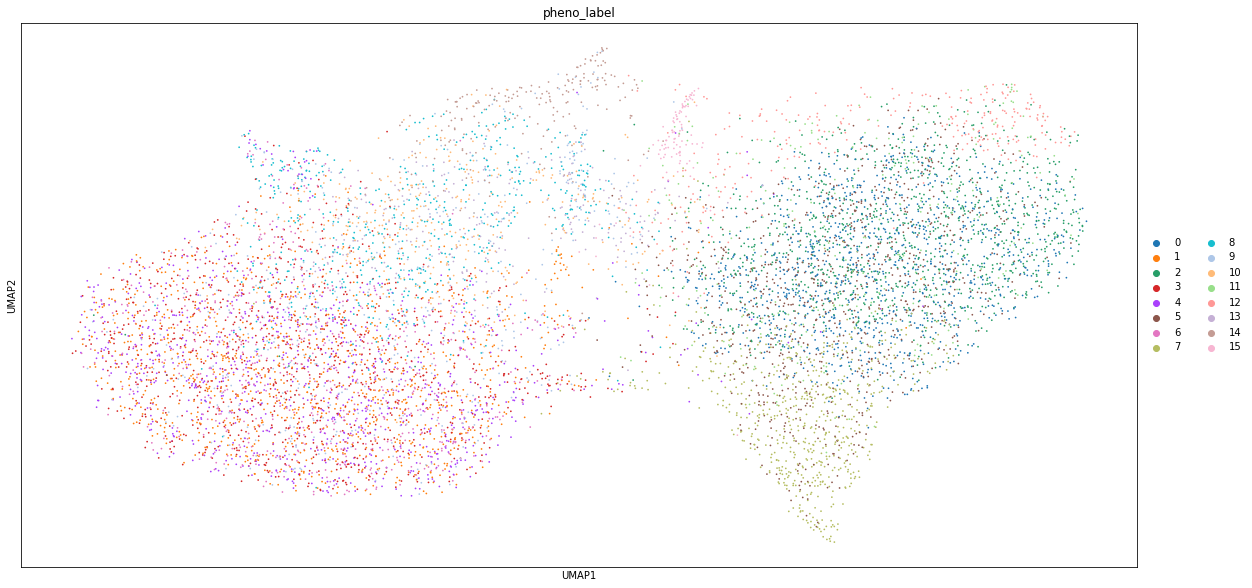

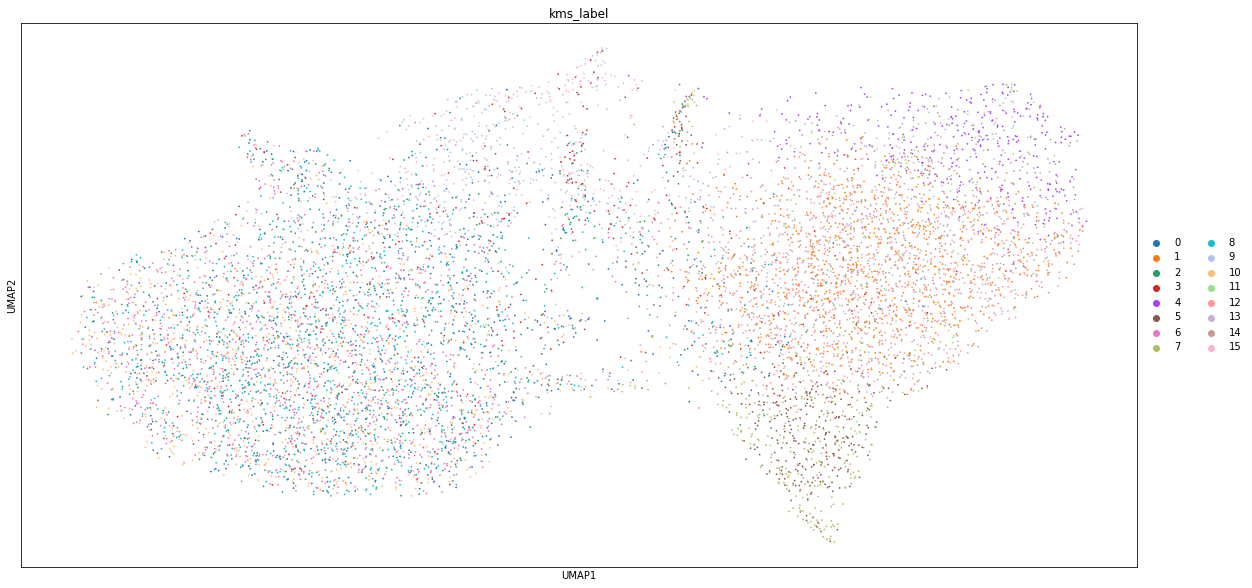

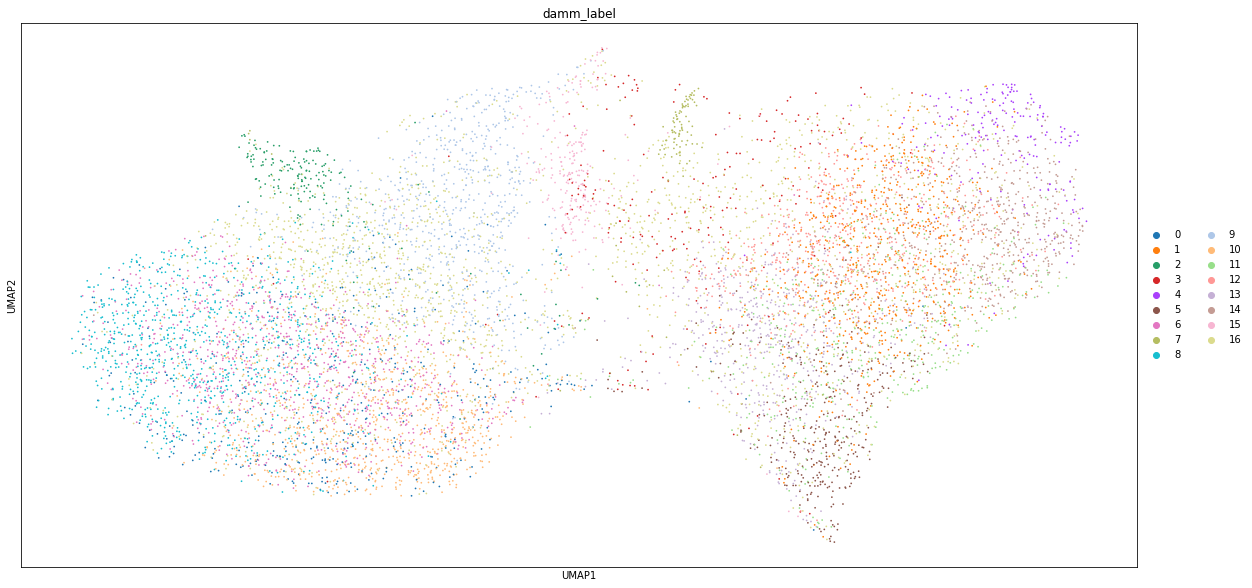

In [28]:
## compute neighbors for UMAP
sc.pp.neighbors(tr_exp, use_rep='X')
sc.tl.umap(tr_exp)

sc.pl.umap(tr_exp, color="pheno_label")
sc.pl.umap(tr_exp, color="kms_label")
sc.pl.umap(tr_exp, color="damm_label")

# Correlation PhenoGraph/Kmeans/DAMM

In [29]:
## PhenoGraph
df_corr = pd.DataFrame(np.array(pheno_centers), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.5161795632916051
correlation between CD45 vs CD8:           0.6422575523608224
correlation between CD45 vs CD11b:         -0.3787811498605829
correlation between CD45 vs CD19:          -0.2704855882441341
correlation between CD45 vs CD28:          0.5693562074619073
correlation between CD45 vs CD68:          -0.2399496188001671
correlation between CD4 vs CD8:            0.9048719363294377
correlation between CD4 vs CD28:           0.967075938904392
correlation between CD8 vs CD28:           0.9425087239619587
correlation between Stroma vs CD31:        0.35124639373572797
correlation between Stroma vs Epithelium:  -0.34557092567612735
correlation between Epithelium vs CD4:     -0.3886251697975669
correlation between Epithelium vs CD8:     -0.1273681124615954
correlation between Epithelium vs CD11b:   -0.09016700022746081
correlation between Epithelium vs CD31:    -0.030231719167178487
correlation between Epithelium vs CD19:    -0.369189345898

In [30]:
## kmeans
df_corr = pd.DataFrame(np.array(kms_centers), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.5784140285949247
correlation between CD45 vs CD8:           0.7673088894993549
correlation between CD45 vs CD11b:         -0.46816103420578414
correlation between CD45 vs CD19:          -0.31404486552326233
correlation between CD45 vs CD28:          0.5832838933668518
correlation between CD45 vs CD68:          -0.4444060737686348
correlation between CD4 vs CD8:            0.9022174497502294
correlation between CD4 vs CD28:           0.9736475835719272
correlation between CD8 vs CD28:           0.9250109014020883
correlation between Stroma vs CD31:        0.0067913284584925305
correlation between Stroma vs Epithelium:  -0.304483705207635
correlation between Epithelium vs CD4:     -0.396458674506801
correlation between Epithelium vs CD8:     -0.040008200263663245
correlation between Epithelium vs CD11b:   -0.0288790602752386
correlation between Epithelium vs CD31:    0.42333967291644237
correlation between Epithelium vs CD19:    -0.56747496141

In [31]:
## damm
df_corr = pd.DataFrame(np.array(damm_centers), columns = pretty_printing).corr()
print("correlation between CD45 vs CD4:           {}".format(df_corr.loc['CD45','CD4']))
print("correlation between CD45 vs CD8:           {}".format(df_corr.loc['CD45','CD8']))
print("correlation between CD45 vs CD11b:         {}".format(df_corr.loc['CD45','CD11b']))
print("correlation between CD45 vs CD19:          {}".format(df_corr.loc['CD45','CD19']))
print("correlation between CD45 vs CD28:          {}".format(df_corr.loc['CD45','CD28']))
print("correlation between CD45 vs CD68:          {}".format(df_corr.loc['CD45','CD68']))

print("correlation between CD4 vs CD8:            {}".format(df_corr.loc['CD4','CD8']))
print("correlation between CD4 vs CD28:           {}".format(df_corr.loc['CD4','CD28']))
print("correlation between CD8 vs CD28:           {}".format(df_corr.loc['CD8','CD28']))

print("correlation between Stroma vs CD31:        {}".format(df_corr.loc['Stroma','CD31']))
print("correlation between Stroma vs Epithelium:  {}".format(df_corr.loc['Stroma','Epithelium']))

print("correlation between Epithelium vs CD4:     {}".format(df_corr.loc['Epithelium','CD4']))
print("correlation between Epithelium vs CD8:     {}".format(df_corr.loc['Epithelium','CD8']))
print("correlation between Epithelium vs CD11b:   {}".format(df_corr.loc['Epithelium','CD11b']))
print("correlation between Epithelium vs CD31:    {}".format(df_corr.loc['Epithelium','CD31']))
print("correlation between Epithelium vs CD19:    {}".format(df_corr.loc['Epithelium','CD19']))
print("correlation between Epithelium vs CD45:    {}".format(df_corr.loc['Epithelium','CD45']))

correlation between CD45 vs CD4:           0.5172717281380985
correlation between CD45 vs CD8:           0.7513544736269524
correlation between CD45 vs CD11b:         0.4142632873346781
correlation between CD45 vs CD19:          -0.3112907990910874
correlation between CD45 vs CD28:          0.7076707358909726
correlation between CD45 vs CD68:          0.19776261542163923
correlation between CD4 vs CD8:            0.7977355267648476
correlation between CD4 vs CD28:           0.9460794170820918
correlation between CD8 vs CD28:           0.8825475441102247
correlation between Stroma vs CD31:        0.26856687473640967
correlation between Stroma vs Epithelium:  -0.22635800977824147
correlation between Epithelium vs CD4:     -0.14908716160146362
correlation between Epithelium vs CD8:     0.2517519252055658
correlation between Epithelium vs CD11b:   0.5411963637877448
correlation between Epithelium vs CD31:    0.28592946123477153
correlation between Epithelium vs CD19:    -0.3651909983463995

# Cell sizes by cluster

<AxesSubplot:xlabel='cluster', ylabel='size'>

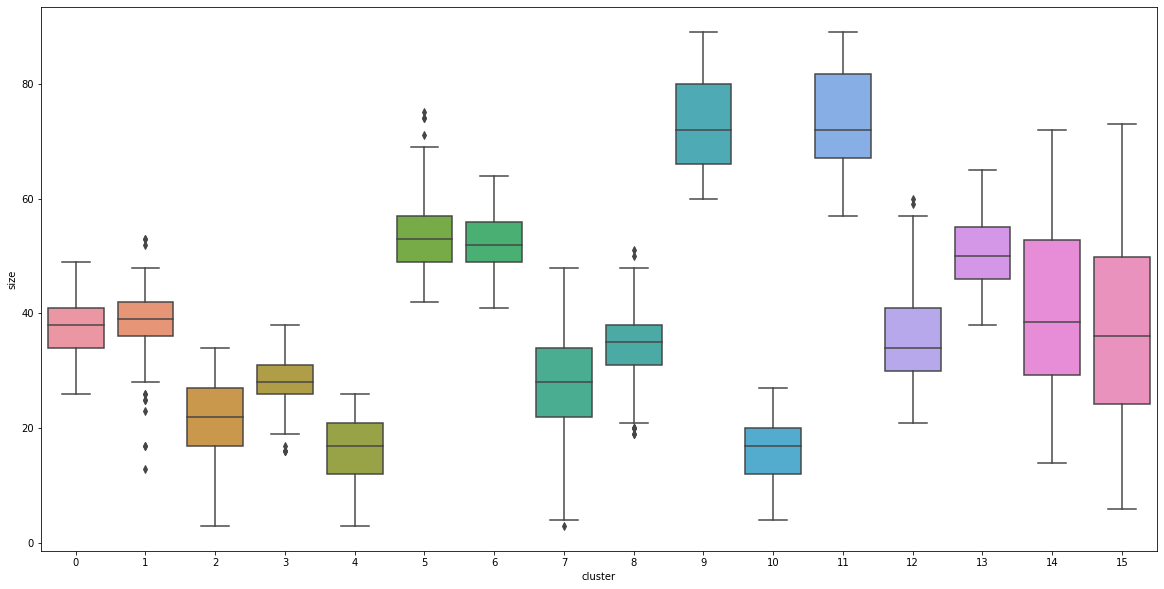

In [32]:
## phenograph
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': pheno_labels})
d3 = d2.merge(d1, on='cluster')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

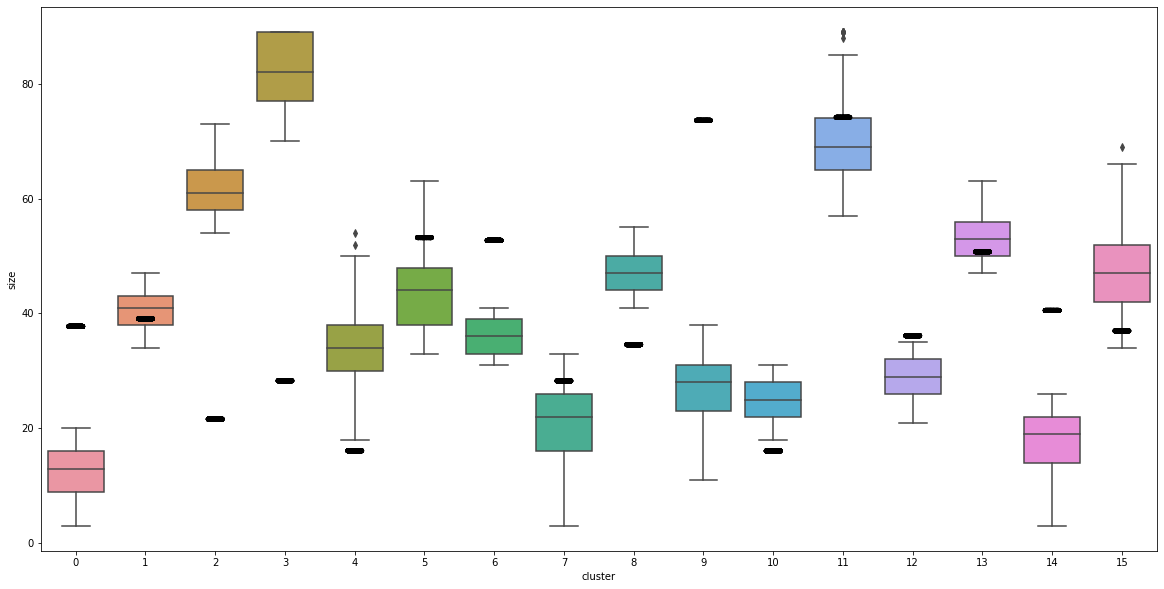

In [33]:
## kmeans
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS, 'cluster': kms_labels})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

<AxesSubplot:xlabel='cluster', ylabel='size'>

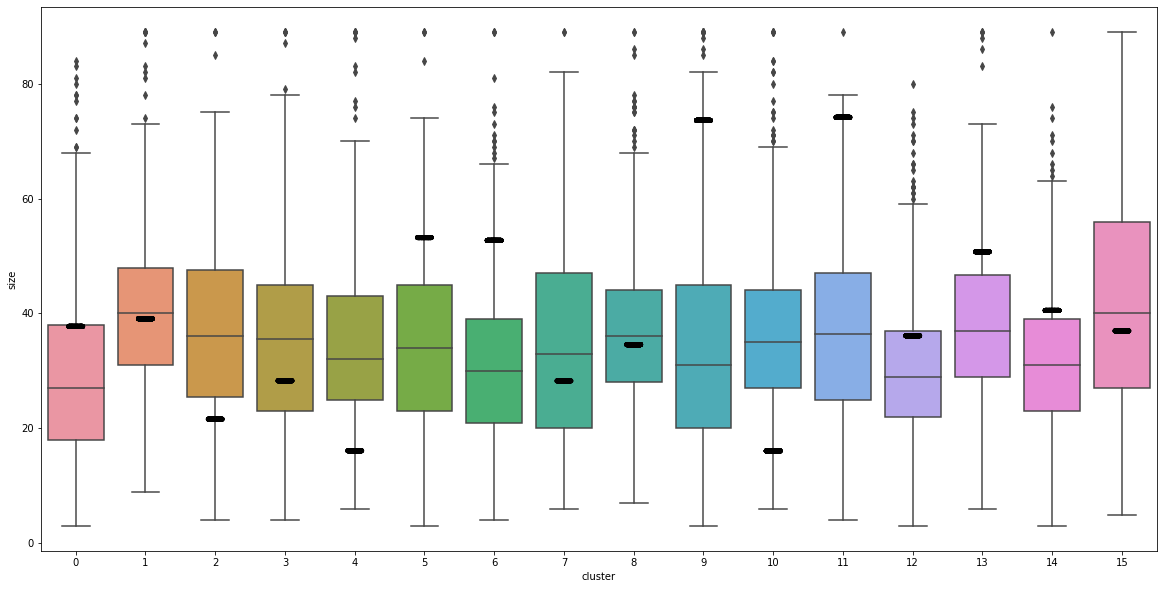

In [34]:
## damm
d1 = pd.DataFrame({'cluster': range(pheno_centers.shape[0]), 'psi': pheno_centers[:,-1]})
d2 = pd.DataFrame({'size': trS[damm_pred_singlet_label[0] == 0], 
                   'cluster': np.array(damm_pred_singlet_cluster_assig_label[0].detach())})
d3 = d2.merge(d1, on='cluster')

sns.stripplot(x = 'cluster', y = 'psi', data = d3, color = 'black')
sns.boxplot(x = 'cluster', y = 'size', data = d3)

# ARS of PhenoGraph/Kmeans/DAMM

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(tr_exp.obs['damm_label'], tr_exp.obs['kms_label'])

0.09521165685918279

In [36]:
adjusted_rand_score(tr_exp.obs['damm_label'], tr_exp.obs['pheno_label'])

0.11391261654688398

In [37]:
adjusted_rand_score(tr_exp.obs['kms_label'], tr_exp.obs['pheno_label'])

0.42475764566066193